In [19]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random
import glob
import csv
import datetime

seed = 6969
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

import pathlib
replays_dir = pathlib.Path("replays")

import os
model_dir = "model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [20]:
# Try to overfit on a small sample to confirm the model is working
mode = "sample"
# Use full dataset
# mode = "full"

# Quiet Water - 7e8f11
# Watch Me Dance! - d90a11
# Sequence Breaker - 31fbd91
# Atomic - 220f2xxx91
# BREAKSH!T - 27e38x11
sample_maps = ["27e38x11"]

pre_segment_size = 12
post_segment_size = 12
prediction_size = 1
segment_size = pre_segment_size + post_segment_size + prediction_size

note_size = 47

input_shape = (segment_size, note_size)

batch_size = 256

In [21]:
def get_replays_for_leaderboard(leaderboard_dir):
    return glob.glob(f"{replays_dir}/{leaderboard_dir}/*.npy")


def load_leaderboards():
    # leaderboard_dir format: id-njs-name
    # leaderboard format: (dir, id, njs, name, replays)

    leaderboard_dirs = [d.name for d in replays_dir.iterdir() if d.is_dir()]
    leaderboards = [[leaderboard_dir] + leaderboard_dir.split("-") for leaderboard_dir in leaderboard_dirs]
    for leaderboard in leaderboards:
        leaderboard[2] = float(leaderboard[2])
        leaderboard.append(get_replays_for_leaderboard(leaderboard[0]))
    return leaderboards


def split_leaderboards(leaderboards):
    if mode == "sample":
        # sampled_leaderboards = random.sample(leaderboards, sample_size)
        sampled_leaderboards = [leaderboard for leaderboard in leaderboards if leaderboard[1] in sample_maps]
        return sampled_leaderboards, sampled_leaderboards
    else:
        train_leaderboards, test_leaderboards = train_test_split(leaderboards, test_size=0.2)
        return train_leaderboards, test_leaderboards

In [22]:
def get_replay_notes(replay, njs):
	notes = []

	prev_red_note_time = 0
	prev_blue_note_time = 0

	for note_info, accpercent, note_time in sorted(replay, key=lambda item: item[2]):
		color = note_info[-2]

		delta_to_red = note_time - prev_red_note_time
		delta_to_blue = note_time - prev_blue_note_time

		if color == "0":
			prev_red_note_time = note_time
			note = preprocess_note(accpercent, delta_to_red, delta_to_blue, note_info, njs)
			notes.append(note)
		if color == "1":
			prev_blue_note_time = note_time
			note = preprocess_note(accpercent, delta_to_blue, delta_to_red, note_info, njs)
			notes.append(note)

	return notes


def preprocess_note(accpercent, delta_to_same_color, delta_to_opposite_color, note_info, njs):
	# delta_to_same_color_short = max(0, 0.5 - delta_to_same_color)*2
	# delta_to_same_color_long = max(0, 2 - delta_to_same_color)/2
	# delta_to_opposite_color_short = max(0, 0.5 - delta_to_opposite_color)*2
	# delta_to_opposite_color_long = max(0, 2 - delta_to_opposite_color)/2

	col_number = int(note_info[1])
	row_number = int(note_info[2])

	color = int(note_info[3])
	direction_number = int(note_info[4])

	row_col_red = [0] * 4 * 3
	direction_red = [0] * 10
	row_col_blue = [0] * 4 * 3
	direction_blue = [0] * 10
	if color == 0:
		row_col_red[col_number * 3 + row_number] = 1
		direction_red[direction_number] = 1
	elif color == 1:
		row_col_blue[col_number * 3 + row_number] = 1
		direction_blue[direction_number] = 1

	delta_to_red = delta_to_same_color if color == 0 else delta_to_opposite_color
	delta_to_blue = delta_to_same_color if color == 1 else delta_to_opposite_color

	response = []
	response.extend(row_col_red)
	response.extend(direction_red)
	response.extend(row_col_blue)
	response.extend(direction_blue)
	response.append(delta_to_red)
	response.append(delta_to_blue)
	# response.append(njs / 30)
	response.append(njs)
	response.append(accpercent)

	return response


def create_segments(notes):
	# NOTE: using relative score can be good to find relative difficulty of the notes more fairly
	# because good players will always get higher acc and worse players will do badly even on easy patterns

	if len(notes) < prediction_size:
		return ([], [])

	segments = []
	accpercents = []

	# Iterate with a step size of prediction_size to achieve non-overlapping segments
	for i in range(0, len(notes) - prediction_size + 1, prediction_size):
		# note[:-1] is result from preprocess_note except the accpercent

		pre_slice = notes[max(0, i - pre_segment_size) : i]
		pre_segment = [np.array(note[:-1]) for note in pre_slice]
		if len(pre_segment) < pre_segment_size:
			# Insert zeros at start of pre_segment
			pre_segment[0:0] = [
				np.zeros(note_size, dtype=np.float32)
				for _ in range(pre_segment_size - len(pre_segment))
			]

		slice = notes[i : i + prediction_size]
		segment = [np.array(note[:-1]) for note in slice]

		post_slice = notes[
			i + prediction_size : i + prediction_size + post_segment_size
		]
		post_segment = [np.array(note[:-1]) for note in post_slice]
		if len(post_segment) < post_segment_size:
			# Insert zeros at end of pre_segment
			post_segment.extend([
				np.zeros(note_size, dtype=np.float32)
				for _ in range(post_segment_size - len(post_segment))
			])

		# ASK: What does this comment mean
		# fix this pls
		segment_accpercents = [note[-1] for note in slice]

		final_segment = []
		final_segment.extend(pre_segment)
		final_segment.extend(segment)
		final_segment.extend(post_segment)
		segments.append(final_segment)

		accpercents.append(segment_accpercents)

	return segments, accpercents


def to_id(value):
	# This is to accomodate V3 scoring somehow
	# id format: (scoring type + 2) * 10000 + line index * 1000 + note line layer * 100 + color * 10 + direction
	if int(value) < 30000:
		# print(f"orig {int(value)}")
		return str(30000 + int(value))
	return str(int(value))


def preprocess_leaderboard_replays(leaderboard):
	# replay note format: (id, acc, spawn time)
	# note_data format: (id, [accs], total spawn time, num occurences)
	# processed_notes format: (id, avg acc, avg spawn time)

	replays = []
	note_data = {}

	# Load and sort each replay by note time
	for leaderboard_replay in leaderboard[4]:
		notes = np.load(leaderboard_replay)
		replays.append(notes[np.argsort(notes[:, 2])])

	# Process each replay to aggregate note data
	for replay in replays:
		i = 0
		for note in replay:
			# PROBLEM: Times are different with different replays
			# If only to_id(note[0]) is used, then there is no differentiation between notes in same position/direction
			# Using i as a temporary solution, not sure if different replays have different note orderings
			# note_id_time_key = to_id(note[0]) + str(note[2] * 100)

			# Temporary solution: only accept normal non-V3 notes
			if to_id(note[0])[0] != "3":
				continue

			note_key = i
			i += 1
			if note_key not in note_data:
				note_data[note_key] = [to_id(note[0]), [note[1]], note[2], 1]
			else:
				note_data[note_key][1].append(note[1])
				note_data[note_key][2] += note[2]
				note_data[note_key][3] += 1

	# Filter and average note data
	processed_notes = []
	for note in note_data.values():
		# If mapping extensions
		if len(note[0]) > 5:
			return ([], [])

		accpercents = note[1]
		avg_accpercent = sum(accpercents) / len(accpercents)
		processed_notes.append([note[0], avg_accpercent, note[2] / note[3]])

	# Generate segments from the processed notes
	notes = get_replay_notes(processed_notes, float(leaderboard[2]))
	segments = create_segments(notes)
	return segments


def generate_data(leaderboards):
	all_segments = []
	all_accpercents = []

	for leaderboard in leaderboards:
		segments, accpercents = preprocess_leaderboard_replays(leaderboard)
		if len(segments) == 0:
			continue

		all_segments.extend(segments)
		all_accpercents.extend(accpercents)

	return np.array(all_segments), np.array(all_accpercents)


def check_replays_consistency(leaderboards):
	for leaderboard in leaderboards:
		replays = []

		# Load and sort each replay by note time
		for leaderboard_replay in leaderboard[4]:
			notes = np.load(leaderboard_replay)
			replays.append(notes[np.argsort(notes[:, 2])])

		# Check if replay has multiple of same note ID and times
		for i in range(len(replays)):
			note_id_time_keys = {}
			for j in range(len(replays[i])):
				note = replays[i][j]

				# Temporary solution: only accept normal non-V3 notes
				if to_id(note[0])[0] != "3":
					continue

				note_id_time_key = to_id(note[0]) + str(note[2] * 100)
				if note_id_time_key not in note_id_time_keys:
					note_id_time_keys[note_id_time_key] = []
				note_id_time_keys[note_id_time_key].append(j)

			for note_id_time_key, note_indices in note_id_time_keys.items():
				if len(note_indices) > 1:
					print(f"{leaderboard[3]} has {len(note_indices)} duplicate note in {leaderboard[4][i]}: {[replays[i][note_index] for note_index in note_indices]}")
					pass

		# Check replays total note count that dont match others
		# mismatched_replays = 0
		# for i in range(1, len(replays)):
		# 	if len(replays[i]) != len(replays[0]):
		# 		print(f"{leaderboard[3]} replay length differs: {leaderboard[4][i]} {len(replays[i])} vs {leaderboard[4][0]} {len(replays[0])}")
		# 		continue
		# 	mismatched_notes = 0
		# 	for j in range(len(replays[i])):
		# 		if replays[i][j][0] != replays[0][j][0]:
		# 			# print(f"{leaderboard[3]} mismatch on note {j}: {leaderboard[4][i]} {replays[i][j][0]} vs {leaderboard[4][0]} {replays[0][j][0]}")
		# 			mismatched_notes += 1
		# 	# print(f"{leaderboard[3]} mismatcheed notes: {mismatched_notes}")
		# 	if mismatched_notes > 0:
		# 		mismatched_replays += 1
		# # print(f"{leaderboard[3]} mismatcheed replays: {mismatched_replays}")

In [23]:
def accpercent_to_percent(accpercent):
	return (accpercent * 15 + 100) / 115 * 100

def examine_samples(leaderboards, model=None):
	for examine_leaderboard_id in sample_maps:
		examine_leaderboard = next((leaderboard for leaderboard in leaderboards if leaderboard[1] == examine_leaderboard_id), None)
		examine_x, examine_y = generate_data([examine_leaderboard])

		real_percents = []
		for note in examine_y:
			real_percents.append(accpercent_to_percent(note[0]))

		pred_percents = []
		if model is not None:
			examine_pred = model(examine_x)
			for note in examine_pred:
				pred_percents.append(accpercent_to_percent(note.numpy()[0][0]))

		overall_real_percent = round(sum(real_percents) / len(real_percents), 2)

		overall_pred_percent = None
		if model is not None:
			overall_pred_percent = round(sum(pred_percents) / len(pred_percents), 2)

		plt.figure(figsize=(6, 4))
		plt.title(f"{examine_leaderboard[3]} ({examine_leaderboard[1]}) - Real percent: {overall_real_percent}{f" - Pred percent: {overall_pred_percent}" if model is not None else ""}")

		convolution_size = round(len(real_percents) / 100) + 1

		real_percents_smoothed = np.convolve(real_percents, np.ones(convolution_size) / convolution_size, mode="valid")
		x_real = [i for i in range(len(real_percents_smoothed))]
		plt.plot(x_real, real_percents_smoothed, label="Real Percent")

		if model is not None:
			pred_percents_smoothed = np.convolve(pred_percents, np.ones(convolution_size) / convolution_size, mode="valid")
			x_pred = [i for i in range(len(pred_percents_smoothed))]
			plt.plot(x_pred, pred_percents_smoothed, label="Pred Percent")

		plt.xlabel("Note #")
		plt.ylabel("Percent")
		plt.tick_params(axis="x")
		plt.tick_params(axis="y")
		plt.xlim(0, len(x_real) - 1)
		plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
		plt.legend()

		plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
		plt.show()

In [24]:
leaderboards = load_leaderboards()
train_leaderboards, test_leaderboards = split_leaderboards(leaderboards)

train_x, train_y = generate_data(train_leaderboards)
test_x, test_y = generate_data(test_leaderboards)

check_replays_consistency(leaderboards)
examine_samples(leaderboards)

BREAKSHT
BREAKSHT
Distorted Heavens has 2 duplicate note in replays/2185bxxxx11-14-Distorted Heavens/76561198400393482-Sensei WU.npy: [array([3.10080000e+04, 9.50395425e-01, 1.58100006e+02]), array([3.10080000e+04, 9.50395425e-01, 1.58100006e+02])]
We Could Get More Machinegun Psystyle and More Genre Switches has 2 duplicate note in replays/17e0271-22-We Could Get More Machinegun Psystyle and More Genre Switches/2169974796454690-JOY.npy: [array([3.12000000e+04, 7.81932831e-01, 9.49479599e+01]), array([3.12000000e+04, 7.81932831e-01, 9.49479599e+01])]
FLASHBACK has 2 duplicate note in replays/1860571-17-FLASHBACK/76561198410971373-Blep 3.npy: [array([31016.        ,     0.        ,   252.53572083]), array([31016.        ,     0.        ,   252.53572083])]


In [ ]:
from keras import Input, Model, layers

# Input layer
input_layer = Input(shape=input_shape)

bidirectional_1 = layers.Bidirectional(layers.LSTM(units=12, return_sequences=True, activation="tanh"), backward_layer=layers.LSTM(units=12, return_sequences=True, go_backwards=True, activation="tanh"))(input_layer)
bidirectional_2 = layers.Bidirectional(layers.LSTM(units=10, return_sequences=True, activation="tanh"), backward_layer=layers.LSTM(units=10, return_sequences=True, go_backwards=True, activation="tanh"))(bidirectional_1)

# Concatenate the output of the second bidirectional LSTM layer with the input
concatenate = layers.Concatenate()([bidirectional_2, input_layer])

# Cropping1D layer
cropping1d = layers.Cropping1D(cropping=(12, 12))(concatenate)  # Adjust the cropping as necessary

# TimeDistributed layer with Dense layer inside
time_distributed_1 = layers.TimeDistributed(layers.Dense(units=16, activation="relu"))(cropping1d)

# Another TimeDistributed layer with Dense layer inside
time_distributed_2 = layers.TimeDistributed(layers.Dense(units=16, activation="relu"))(time_distributed_1)

# Final TimeDistributed layer with Dense layer for output
time_distributed_3 = layers.TimeDistributed(layers.Dense(units=1, activation="linear"))(time_distributed_2)

# Create the model
model = Model(inputs=input_layer, outputs=time_distributed_3)

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss=tf.keras.losses.MeanAbsoluteError(reduction="sum_over_batch_size"),
    metrics=['mse'],
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 47)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 25, 24)    │      5,760 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 25, 20)    │      2,800 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 25, 67)    │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping1d          │ (None, 1, 67)     │          0 │ concatenate[0][0] │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 1, 16)     │      1,088 │ cropping1d[0][0]  │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 1, 16)     │        272 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 1, 1)      │         17 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,937 (38.82 KB)

 Trainable params: 9,937 (38.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

global initial_epoch
initial_epoch = 0
class EpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global initial_epoch
        initial_epoch += 1

In [ ]:
train_epochs = 300

history = model.fit(
    train_x,
    train_y,
    validation_data=(test_x, test_y),
    callbacks=[tensorboard_callback, EpochCallback()],
    batch_size=128,
    epochs=initial_epoch + train_epochs,
    initial_epoch=initial_epoch,
    shuffle=True,
    verbose=1,
)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - loss: 0.6134 - mse: 0.4171 - val_loss: 0.9180 - val_mse: 1.0914
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.9182 - mse: 1.1007 - val_loss: 0.2328 - val_mse: 0.1661
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2667 - mse: 0.1929 - val_loss: 0.6428 - val_mse: 0.4266
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.6332 - mse: 0.4150 - val_loss: 0.1792 - val_mse: 0.0421
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2032 - mse: 0.0619 - val_loss: 0.6141 - val_mse: 0.3950
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5844 - mse: 0.3736 - val_loss: 0.3515 - val_mse: 0.1448
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3518 - mse: 0.1451 - val_loss: 0.2785 - val_mse: 0.0846
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2662 - mse: 0.0791 - val_loss: 0.3979 - val_mse: 0.2247
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.4079 - mse:

In [ ]:
import tf2onnx

if mode == "full":
    model.save(f"{model_dir}/model.keras")

    spec = (tf.TensorSpec((None, segment_size, note_size), tf.float32),)
    model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=None, output_path=f"{model_dir}/model.onnx")

BREAKSHT
skip 42011
skip 53013
skip 41002
skip 50001
skip 42011
skip 53110
skip 42002
skip 51001
skip 42011
skip 51000
skip 53113
skip 52011
skip 53013
skip 52011
skip 43003
skip 51002
skip 42011
skip 52110
skip 41001
skip 50104
skip 42011
skip 51001
skip 52010
skip 72018
skip 72118
skip 72118
skip 62111
skip 72118
skip 61101
skip 71108
skip 71108
skip 71008
skip 62010
skip 72018
skip 72118
skip 71108
skip 61000
skip 41001
skip 51208
skip 42011
skip 41001
skip 52011
skip 51001
skip 40102
skip 43113
skip 42011
skip 42011
skip 41001
skip 41001
skip 42011
skip 41001
skip 61101
skip 71108
skip 71108
skip 71008
skip 42011
skip 42011
skip 41001
skip 62111
skip 72118
skip 72118
skip 72018
skip 41001
skip 41012
skip 41001
skip 51000
skip 41001
skip 52000
skip 40000
skip 51001
skip 42003
skip 50102
skip 42011
skip 53013
skip 41002
skip 50001
skip 42011
skip 53110
skip 42002
skip 51001
skip 42011
skip 51000
skip 53113
skip 52011
skip 53013
skip 52011
skip 43003
skip 51002
skip 42011
skip 52110
s

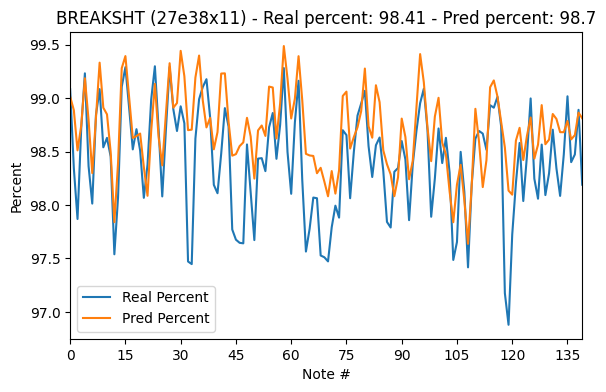

In [ ]:
examine_samples(leaderboards, model)

In [ ]:
# predictions = []
# for leaderboard_id, leaderboard_replays in test_data:
#     try:
#         curr, score = preprocess_leaderboard_replays(leaderboard_replays)

#         _predictions = model.predict(np.array(curr))

#         real_sum = 0
#         for prediction in score:
#             real_sum += prediction[0]

#         real_avg = real_sum / len(score)
#         real_percentage_score = (100 + real_avg * 15) / 115

#         prediction_sum = 0
#         for prediction in _predictions:
#             prediction_sum += prediction[0]

#         avg = prediction_sum / len(_predictions)
#         percentage_score = (100 + avg[0] * 15) / 115

#         predictions.append(
#             [
#                 f"https://beatleader.xyz/leaderboard/global/{leaderboard_id}",
#                 round(percentage_score, 5),
#                 round(real_percentage_score, 5),
#                 abs(round(real_percentage_score - percentage_score, 5)),
#             ]
#         )
#     except KeyboardInterrupt:
#         raise
#     except Exception as e:
#         print(e)
#         continue
# with open(f"{model_dir}/predictions.csv", "w", newline="", encoding="utf-8") as f:
#     writer = csv.writer(f)
#     header = ["LeaderboardId", "Prediction", "Expected", "Difference"]
#     writer.writerow(header)

#     for prediction in predictions:
#         writer.writerow(prediction)